# Precipitation Seasonal Climatology

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from pathlib import Path
from IPython.display import Image, display
from scipy.ndimage import gaussian_filter

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from ar_funcs import preprocess_ar_area_subregions, add_ar_time_series
from timeseries import calc_seasonal_contribution
import nclcmaps as nclc

### Set up paths

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


## Data

In [4]:
# start date and end date
start_date = '1979-01-01'
end_date = '2018-12-31'

# Select lat/lon grid
lonmin = 60
lonmax = 110
latmin = 15
latmax =  50

### AR time series

In [5]:
# read netCDF with fraction of area AR covers each subregion
filename = path_to_data + 'CH1_generated_data/ar_catalog_ERAI_fraction_HASIAsubregions.nc'
ds = xr.open_dataset(filename)

# Set dates
ds = ds.sel(time=slice(start_date, end_date))

## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()


,R01,R02,R03,ar,location
time,,,,,
1979-01-01,0.000000,0.0,0.0,0,NaN
1979-01-02,0.000000,0.0,0.0,0,NaN
1979-01-03,0.005102,0.0,0.0,0,NaN
1979-01-04,0.000000,0.0,0.0,0,NaN
1979-01-05,0.000000,0.0,0.0,0,NaN


In [6]:
## venn diagram for overlap of different regions for AR days


### ERA5 reanalysis

In [15]:
### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

filepath_pattern = path_to_data + 'ERA5/prec/daily/out.era5*.nc'
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

# Create new dataset to rename lat lon
era = xr.Dataset({'prec': (['time', 'lat', 'lon'], f1['mtpr'].values*86400)},
                      coords={'time': (['time'], f1.time.values),
                              'lat': (['lat'], f1.latitude.values),
                              'lon': (['lon'], f1.longitude.values)})

era = era.sel(time=slice(start_date, end_date))
era

ds size in GB 1.66



<xarray.Dataset>
Dimensions:  (lat: 141, lon: 201, time: 14610)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T15:00:00 ... 2018-12-31T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 15.75 15.5 15.25 15.0
  * lon      (lon) float32 60.0 60.25 60.5 60.75 ... 109.25 109.5 109.75 110.0
Data variables:
    prec     (time, lat, lon) float64 -8.047e-05 -8.047e-05 ... 17.81 14.17

### Climatology

In [23]:
# put all precip ds into list
ds_list = [era]
prec_var = ['prec']

ds_clim_djf, ds_frac_djf, ds_std_djf = calc_seasonal_contribution(ds_list=ds_list, df=df, prec_var=prec_var, mon_s=12, mon_e=2)
ds_clim_mam, ds_frac_mam, ds_std_mam = calc_seasonal_contribution(ds_list=ds_list, df=df, prec_var=prec_var, mon_s=3, mon_e=5)
ds_clim_son, ds_frac_son, ds_std_son = calc_seasonal_contribution(ds_list=ds_list, df=df, prec_var=prec_var, mon_s=9, mon_e=11)
ds_clim_jja, ds_frac_jja, ds_std_jja = calc_seasonal_contribution(ds_list=ds_list, df=df, prec_var=prec_var, mon_s=6, mon_e=8)


## Create figure

In [24]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# Plot Labels
plt_labels = ['DJF', 'MAM', 'JJA', 'SON']

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]

### Precipitation Plots

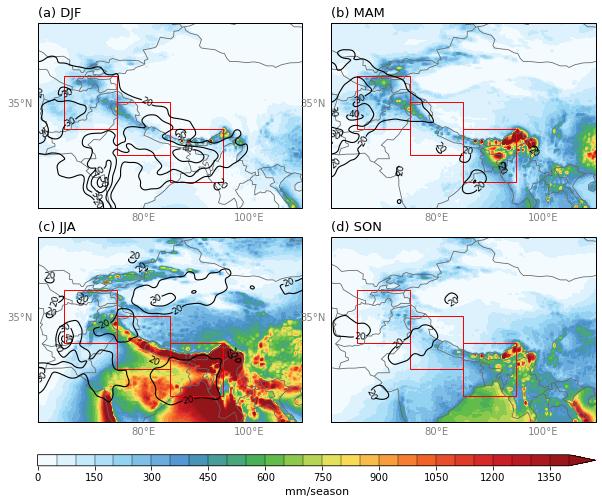

In [27]:
# Data for plotting
lons = era.lon.values
lats = era.lat.values
cf_data = [ds_clim_djf[0], ds_clim_mam[0], ds_clim_jja[0], ds_clim_son[0]]
cl_data = [ds_frac_djf[0], ds_frac_mam[0], ds_frac_jja[0], ds_frac_son[0]]

# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.40,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

# cmap = nclc.cmap('WhiteBlueGreenYellowRed')
# cmap=my_cmap
cmap = cmo.rain
clipcmap = cmocean.tools.crop_by_percent(cmap, 20, which='min', N=None)
cmap = nclc.cmap('WhiteBlueGreenYellowRed')
cflevs = np.arange(0., 1450., 50)
plt_labels = ['(a) DJF', '(b) MAM', '(c) JJA', '(d) SON']

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
    # Average Seasonal Total
    cf = ax.contourf(lons, lats, cf_data[k], transform=datacrs,
                    levels=cflevs,cmap=cmap, extend='max')
    
    
    # Contour Lines
    # Percent Contribution
    contr = gaussian_filter(cl_data[k], sigma=2.5)
    clevs = np.arange(20,105,10)
    cs = ax.contour(lons, lats, contr, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    kw_clabels = {'fontsize': 9, 'inline': True, 'inline_spacing': 8, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
cb.set_label('mm/season', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'prec_clim_contribution_all_ssn' + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()